# Homework — Empirical Interpolation Method (EIM)

**Context.** You will implement the Empirical Interpolation Method (EIM) to recover an affine expansion of a non‑affine source term depending on three parameters. The goal is to build the greedy EIM basis and interpolation points ("magic points"), test the online reconstruction from only \(M\) samples, and study stability and error indicators.

**References to the course slides (page numbers):**
- EIM idea & interpolant: pp. 8–11.
- Greedy algorithm (pseudocode): p. 16 (*EIM algorithm i*).
- Properties (lower triangular, unit diagonal): pp. 18–21.
- Error analysis with Lebesgue constant: pp. 23–26.
- One‑point a posteriori estimator: pp. 28–31.
- Practical discretization (algebraic form): pp. 34–38.
- DEIM overview (optional extension): pp. 40–47.

You only need standard Python + NumPy + Matplotlib. Avoid external packages.

**Submission.** When you finish, ensure all `TODO` markers are addressed and the notebook runs top‑to‑bottom producing: (i) the learned EIM basis/points, (ii) an error‑vs‑M plot on a test set, (iii) a plot of the (discrete) Lebesgue constant, and (iv) a plot showing the effectivity of the one‑point estimator.


## 0. Imports & helpers
Do **not** use seaborn or style packages; use plain Matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.random.seed(42)

## 1. Problem setup
We work on $\Omega=[0,1]$. The source depends on three parameters $\mu=(\mu_1,\mu_2,\mu_3)$ and is given by
$$
s(x;\mu) = (1+\mu_1)\,\sin\big((1+\mu_2)\pi x\big) + \exp\big(-20(x-\mu_3)^2\big).
$$
You will approximate $s(\cdot;\mu)$ using EIM so that linear forms become affine in $\mu$ (see slides pp. 3–6).

In [2]:
# Discretize the domain
Nq = 1000
x = np.linspace(0.0, 1.0, Nq)

# Parameter ranges: mu1 in [0,2], mu2 in [0,2], mu3 in [0.2,0.8]
mu_box = np.array([[0.0, 2.0],
                   [0.0, 2.0],
                   [0.2, 0.8]])

def s_fun(x, mu):
    mu1, mu2, mu3 = mu
    return (1+mu1)*np.sin((1+mu2)*np.pi*x) + np.exp(-20.0*(x-mu3)**2)

def sample_mu(n):
    u = np.random.rand(n, 3)
    return mu_box[:,0] + u*(mu_box[:,1]-mu_box[:,0])

# Build training/test parameter sets (adjust sizes if needed)
n_train = 400
n_test  = 200
mu_train = sample_mu(n_train)
mu_test  = sample_mu(n_test)

### Quick visualization (sanity check)
Plot a few random sources to get a feel for the function family.

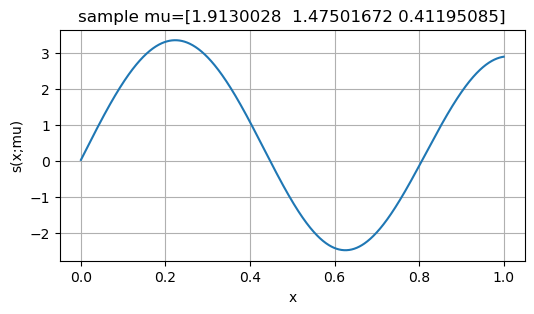

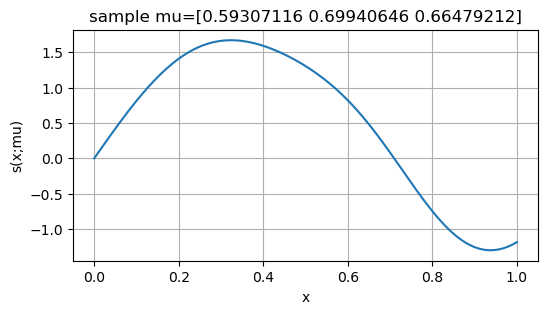

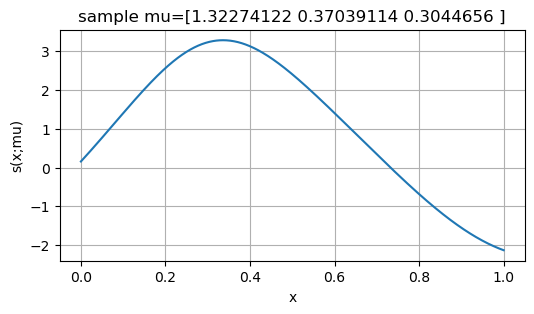

In [3]:
for _ in range(3):
    mu0 = sample_mu(1)[0]
    plt.figure(figsize=(6,3))
    plt.plot(x, s_fun(x, mu0))
    plt.xlabel('x'); plt.ylabel('s(x;mu)'); plt.title(f'sample mu={mu0}')
    plt.grid(True)
    plt.show()

## 2. Building blocks
### 2.1 Lower‑triangular solve (forward substitution)
**Task.** Implement a function that solves \(L\,\gamma = b\) where \(L\) is lower‑triangular with **unit diagonal**.

Hint: This will be used with the interpolation matrix \(B_M = Q_I\) (slides p. 37), which is lower triangular with ones on the diagonal (slides pp. 18–21).

In [4]:
def forward_solve(L, b):
    """
    Solve L x = b for lower-triangular L with ones on the diagonal.
    If b is 2D, solve column-wise.
    TODO: implement forward substitution.
    """
    # --- YOUR CODE HERE ---
    # raise NotImplementedError('forward_solve')
    L = np.asarray(L)
    b = np.asarray(b)
    n = L.shape[0]
    if b.ndim == 1:
        x = np.zeros_like(b, dtype=float)
        for i in range(n):
            x[i] = b[i] - np.dot(L[i, :i], x[:i])
        return x
    else:
        x = np.zeros_like(b, dtype=float)
        for j in range(b.shape[1]):
            for i in range(n):
                x[i, j] = b[i, j] - np.dot(L[i, :i], x[:i, j])
        return x

### 2.2 Data container
We will store the learned basis, point indices, and diagnostics in a simple dataclass.

In [5]:
@dataclass
class EIMModel:
    Q: np.ndarray        # (Nq, M)
    I: list              # magic point indices (length M)
    mu_eim: list         # selected parameters (length M)
    t_history: list      # evolution of magic points (indices) per step
    err_train: list      # training sup-norm errors per M
    lebesgue: list       # discrete Lebesgue constants per M (optional)


## 3. EIM offline (greedy)
**Task.** Implement the greedy EIM algorithm to build $Q=[\rho_1|\dots|\rho_M]$ and the set of indices $I=\{i_1,\dots,i_M\}$.

Use the practical, *discrete* version on the grid $\Omega_h=\{x_k\}_{k=1}^{N_q}$ and on the training set $\Xi_{\text{train}}$. See slides pp. 34–38 for the algebraic form and p. 16 for the greedy pseudocode.

Minimal checklist:
- Start with $\mu_1 = \arg\max_\mu \|g(\cdot;\mu)\|_\infty$, set $\xi_1=g(\cdot;\mu_1)$. Pick $t_1=\arg\max_x |\xi_1(x)|$, define $\rho_1=\xi_1/\xi_1(t_1)$.
- At step $m+1$: pick $\mu_{m+1}$ maximizing the current error, set residual $r_{m+1}=\xi_{m+1}-I_m^x\xi_{m+1}$, choose $t_{m+1}=\arg\max |r_{m+1}|$, and $\rho_{m+1}=r_{m+1}/r_{m+1}(t_{m+1})$.
- Maintain the interpolation system $B_m\,\gamma=g_I$ with $B_m=Q_m[I_m,:]$.

In [6]:
def eim_offline(s_fun, x, mu_train, M_max=20, tol=1e-6):
    """Greedy EIM on a discrete grid.
    Returns an EIMModel with fields filled.
    TODO: implement the algorithm described on the slides.
    Hints:
      * Precompute training snapshots S[:,j] = s_fun(x, mu_train[j]).
      * Define a helper that, given Q_m and I_m, reconstructs any snapshot by solving Q_m[I_m,:] gamma = snapshot[I_m].
      * Track the max training sup-norm error after each enrichment.
      * Optionally compute the discrete Lebesgue constant: max_x sum_i |(Q_m B_m^{-1})[x,i]|.
    """
    # --- YOUR CODE HERE ---
    # raise NotImplementedError('eim_offline')
    Nq = len(x)
    S = np.stack([s_fun(x, mu) for mu in mu_train], axis=1)
    
    Q_cols, I, mu_eim = [], [], []
    t_history, err_train, lebesgue = [], [], []

    def reconstruct(Qm, Im):
        if Qm.size == 0: return np.zeros_like(S)
        Bm = Qm[Im,:]
        gI = S[Im,:]
        gamma = forward_solve(Bm, gI)
        return Qm @ gamma

    def compute_lebesgue(Qm, Im):
        if len(Im) == 0: return 0.0
        Bm = Qm[Im,:]
        invB = forward_solve(Bm, np.eye(len(Im)))
        L = Qm @ invB
        return float(np.max(np.sum(np.abs(L), axis=1)))

    # ---- step 1 ----
    norms = np.max(np.abs(S), axis=0)
    j1 = int(np.argmax(norms))
    xi1 = S[:, j1]
    t1 = int(np.argmax(np.abs(xi1)))
    rho1 = xi1 / xi1[t1]
    Q_cols.append(rho1)
    I.append(t1)
    mu_eim.append(mu_train[j1])
    t_history.append(t1)

    Qm = np.column_stack(Q_cols)
    approx = reconstruct(Qm, I)
    err = np.max(np.abs(S - approx))
    err_train.append(err)
    lebesgue.append(compute_lebesgue(Qm, I))

    # ---- greedy loop ----
    while len(I) < M_max and err > tol:
        Qm = np.column_stack(Q_cols)
        approx = reconstruct(Qm, I)
        residuals = S - approx
        errs = np.max(np.abs(residuals), axis=0)
        j_next = int(np.argmax(errs))
        xi = S[:, j_next]
        r = residuals[:, j_next]
        t_next = int(np.argmax(np.abs(r)))
        rho_next = r / r[t_next]
        Q_cols.append(rho_next)
        I.append(t_next)
        mu_eim.append(mu_train[j_next])
        t_history.append(t_next)
        Qm = np.column_stack(Q_cols)
        approx = reconstruct(Qm, I)
        err = np.max(np.abs(S - approx))
        err_train.append(err)
        lebesgue.append(compute_lebesgue(Qm, I))

    Q = np.column_stack(Q_cols)
    return EIMModel(Q=Q, I=I, mu_eim=mu_eim, t_history=t_history,
                    err_train=err_train, lebesgue=lebesgue)

## 4. EIM online
**Task.** Given $Q$ and $I$, reconstruct $s_M(\cdot;\mu) = Q\,\gamma(\mu)$ from just the $M$ samples $s(x_{I_j};\mu)$.

Slides pp. 36–38 show the algebraic online step.

In [7]:
def eim_online(model, x, mu):
    """Return (approx, gamma) with approx in R^{Nq}. Uses only M samples.
    TODO: implement using forward_solve on Q[I,:] and g_I.
    """
    # --- YOUR CODE HERE ---
    # raise NotImplementedError('eim_online')
    Q, I = model.Q, model.I
    B = Q[I, :]
    gI = s_fun(x[I], mu)
    gamma = forward_solve(B, gI)
    approx = Q @ gamma
    return approx, gamma

## 5. Run the offline phase and sanity checks
After you implement `eim_offline`, run it and test the two key properties (slides pp. 18–21):
- `Q[I,:]` is lower triangular with unit diagonal.
- Interpolation property on the training set: for each $\mu$, the interpolant matches the function at the magic points.

In [ ]:
# Uncomment after implementing eim_offline
model = eim_offline(s_fun, x, mu_train, M_max=25, tol=1e-8)
QI = model.Q[model.I,:]
# Triangular + ones on diagonal (numerically)
assert np.allclose(np.diag(QI), 1.0)
assert np.allclose(QI, np.tril(QI), atol=1e-6) ######<------
# Interpolation holds on training samples at magic points
S_train = np.stack([s_fun(x, mu) for mu in mu_train], axis=1)
B = model.Q[model.I,:]
gamma = forward_solve(B, S_train[model.I,:])
interp = model.Q @ gamma
assert np.allclose(interp[model.I,:], S_train[model.I,:])
print('Sanity checks passed.')

Sanity checks passed.


## 6. Error on a test set
**Task.** Compute the test error curve $$\max_{x,\,\mu\,\in\,\text{test}}|s - I_M s|$$ for $$M=1,\dots, M_\text{max}$$.

In [9]:
def test_error_curve(model, x, mu_test):
    """Return an array errs[M-1] with sup error over x,mu for each M.
    TODO: for each m=1..Mmax, solve on the m-by-m system and reconstruct.
    """
    # --- YOUR CODE HERE ---
    # raise NotImplementedError('test_error_curve')
    Q, I = model.Q, model.I
    Mmax = Q.shape[1]
    errs = np.zeros(Mmax)
    for m in range(1, Mmax + 1):
        Qm, Im = Q[:, :m], I[:m]
        Bm = Qm[Im, :]
        max_err = 0.0
        for mu in mu_test:
            gI = s_fun(x[Im], mu)
            gamma = forward_solve(Bm, gI)
            approx = Qm @ gamma
            truth = s_fun(x, mu)
            max_err = max(max_err, np.max(np.abs(truth - approx)))
        errs[m-1] = max_err
    return errs

### Plot: error decay vs. M
Produce a semilog plot of the error vs. $M$. If your training set is representative, you should see rapid decay (cf. the convergence remarks in the slides’ error analysis).

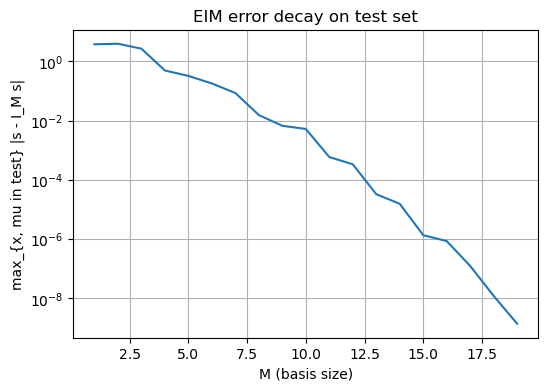

In [10]:
# After implementing test_error_curve and building `model`:
errs = test_error_curve(model, x, mu_test)
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(1, len(errs)+1), errs)
plt.xlabel('M (basis size)')
plt.ylabel('max_{x, mu in test} |s - I_M s|')
plt.title('EIM error decay on test set')
plt.grid(True)
plt.show()

## 7. Discrete Lebesgue constant
Recall the discrete analogue $\Lambda_M = \max_x \sum_i |\ell^M_i(x)|$ where $\ell^M_i$ are the Lagrange functions (slides pp. 23–26). With matrices, this can be computed as `max(sum(abs(Q @ inv(B)), axis=1))` for each \(M\), where `B = Q[I,:]`.

**Task.** Implement a function that returns the sequence $\{\Lambda_m\}_{m=1}^M$.

In [11]:
def discrete_lebesgue_constants(Q, I):
    """Return array [Lambda_1, ..., Lambda_M].
    TODO: loop over m, compute inv(Qm[Im,:]) and the max row-sum norm of Qm @ invB.
    """
    # --- YOUR CODE HERE ---
    # raise NotImplementedError('discrete_lebesgue_constants')
    M = Q.shape[1]
    Ls = np.zeros(M)
    for m in range(1, M + 1):
        Qm, Im = Q[:, :m], I[:m]
        Bm = Qm[Im, :]
        invB = forward_solve(Bm, np.eye(m))
        L = Qm @ invB
        Ls[m-1] = np.max(np.sum(np.abs(L), axis=1))
    return Ls

### Plot: Lebesgue constant growth
Plot $\Lambda_M$ vs. $M$. Compare its growth with what is discussed on the slides (the bound $\Lambda_M \le 2^{M-1}$ is pessimistic).

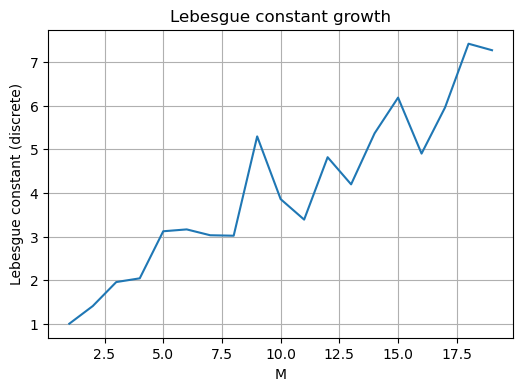

In [12]:
Lambda_seq = discrete_lebesgue_constants(model.Q, model.I)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(Lambda_seq)+1), Lambda_seq)
plt.xlabel('M')
plt.ylabel('Lebesgue constant (discrete)')
plt.title('Lebesgue constant growth')
plt.grid(True)
plt.show()

## 8. One‑point estimator
Let $t_{M+1}$ be the next magic point (recorded during offline). Define $\Delta_M(\mu)=|s(t_{M+1};\mu)-I^x_M s(t_{M+1};\mu)|$. It is a lower bound of the true sup error and equals it if $s(\cdot;\mu)\in X_{M+1}$ (slides pp. 28–31).

**Task.** Implement a function that computes the **median** effectivity $\operatorname{median}_\mu \Delta_M(\mu)/\|s-I^x_M s\|_\infty$ on a test set for $M=1,\dots,M_{\max}-1$.

In [13]:
def one_point_effectivity(model, x, mu_test):
    """Return effectivity ratios (median over test mu) for m=1..M-1.
    TODO: for each m, reconstruct with Q[:,:m], I[:m];
          compute true sup error over x and the one-point delta at t_{m+1}.
    """
    # --- YOUR CODE HERE ---
    # raise NotImplementedError('one_point_effectivity')
    Q, I = model.Q, model.I
    M = Q.shape[1]
    med = np.zeros(M - 1)
    for m in range(1, M):
        Qm, Im = Q[:, :m], I[:m]
        Bm = Qm[Im, :]
        t_next = I[m]
        vals = []
        for mu in mu_test:
            gI = s_fun(x[Im], mu)
            gamma = forward_solve(Bm, gI)
            approx = Qm @ gamma
            truth = s_fun(x, mu)
            true_err = np.max(np.abs(truth - approx))
            delta = np.abs(truth[t_next] - approx[t_next])
            vals.append(delta / (true_err + 1e-15))
        med[m-1] = np.median(vals)
    return med

### Plot: one‑point estimator effectivity
Plot the median effectivity vs. $M$.

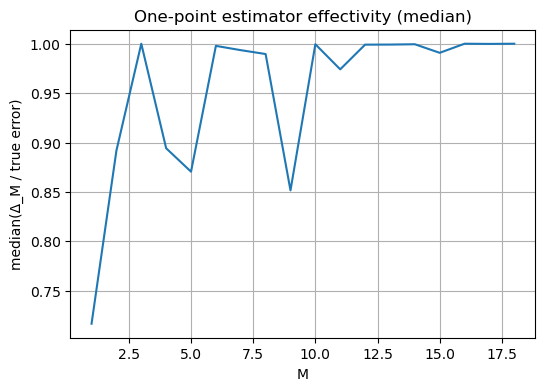

In [14]:
eff = one_point_effectivity(model, x, mu_test)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eff)+1), eff)
plt.xlabel('M')
plt.ylabel('median(Δ_M / true error)')
plt.title('One‑point estimator effectivity (median)')
plt.grid(True)
plt.show()

## 9. Using EIM inside a linear form (short demo)
Consider a test function $v(x)$ and approximate $\int_0^1 s(x;\mu)v(x)\,dx$ with the trapezoidal rule on $\Omega_h$. With EIM, precompute $\int_0^1 \rho_j(x) v(x)\,dx$ once, then online evaluate $\sum_j \gamma_j(\mu)\,\int \rho_j v$. See slides pp. 5–6 and 50–51.

**Task.** Implement the offline precompute and online evaluation for two simple test functions (e.g. `sin(pi x)` and `x(1-x)`). Report absolute errors.

In [15]:
def trapezoid_weights(x):
    w = np.zeros_like(x)
    w[1:-1] = (x[2:] - x[:-2]) / 2.0
    w[0] = (x[1]-x[0]) / 2.0
    w[-1] = (x[-1]-x[-2]) / 2.0
    return w

# --- YOUR CODE HERE (after model is built) ---
w = trapezoid_weights(x)
v1 = np.sin(np.pi*x)
v2 = x*(1-x)
coeff_v1 = np.sum(w[:,None]*model.Q*v1[:,None], axis=0)
coeff_v2 = np.sum(w[:,None]*model.Q*v2[:,None], axis=0)
mu0 = sample_mu(1)[0]
approx, gamma = eim_online(model, x, mu0)
truth_v1 = np.sum(w * s_fun(x, mu0) * v1)
truth_v2 = np.sum(w * s_fun(x, mu0) * v2)
approx_v1 = np.dot(coeff_v1, gamma)
approx_v2 = np.dot(coeff_v2, gamma)
print("abs error v1:", abs(truth_v1 - approx_v1))
print("abs error v2:", abs(truth_v2 - approx_v2))

abs error v1: 1.3139211940682571e-12
abs error v2: 3.4891534106407107e-13


## 10. (Optional) DEIM variant
Reimplement the approximation using a **DEIM** basis (POD of snapshot matrix) while keeping the same greedy selection of indices (slides pp. 40–47). Compare the error vs. the first discarded singular value \(\sigma_{M+1}\).

Checklist:
- Build a snapshot matrix `S` (e.g. using the training set).
- Compute its SVD and form `Q = U[:, :M]`.
- Select indices greedily (same loop as in EIM but on basis columns).
- Online: solve `Q[I,:] gamma = g_I` and reconstruct.
- Compare `||g - g_M||_2` on a test set to `sigma_{M+1}`.


In [16]:
# --- YOUR CODE HERE (optional) ---
pass

## 11. Short questions (answer briefly in markdown)
1. Why is `Q[I,:]` lower triangular with ones on the diagonal? (slides pp. 18–21)
2. State and interpret the Lebesgue‑constant error bound (slides pp. 23–26). When can the bound be pessimistic?
3. Under which condition does the one‑point estimator equal the true $L^\infty$ error? (slides pp. 28–31)


1. Because each new basis function $\rho_{m+1}$ is normalized so that

$\rho_{m+1}(t_{m+1})=1$ and $\rho_j(t_{m+1})=0$ for $j<m$.

Thus $B_M = Q[I,:]$ is lower triangular with unit diagonal.

2. 
$$
|g - I_M g|_\infty \le (1+\Lambda_M)\min_{v\in X_M}\|g - v\|_\infty,
\quad
\Lambda_M=\max_x\sum_i|\ell_i^M(x)|.
$$
$\Lambda_M$ measures interpolation stability.
The bound can be pessimistic since the theoretical limit $\Lambda_M\le2^{M-1}$ is very loose.

3. When $g(\cdot;\mu)\in X_{M+1}$;
then the interpolation error reaches its maximum at $t_{M+1}$,
so $\Delta_M(\mu)=\|g-I_M g\|_\infty.$
